In [1]:
import sys
sys.path.append('/Users/shiyihe/Desktop/USABILITY_ANALYSIS')   
from duration_processor import load_quiz_data
# load data , rename task name, etc,.
folder = '/Users/shiyihe/Desktop/USABILITY_ANALYSIS/tabular'
all_data = load_quiz_data(folder, ignore_completed=True)

/var/folders/hs/htjkkv116fv94g1llc3jj8jc0000gn/T/ipykernel_41946/1443811771.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


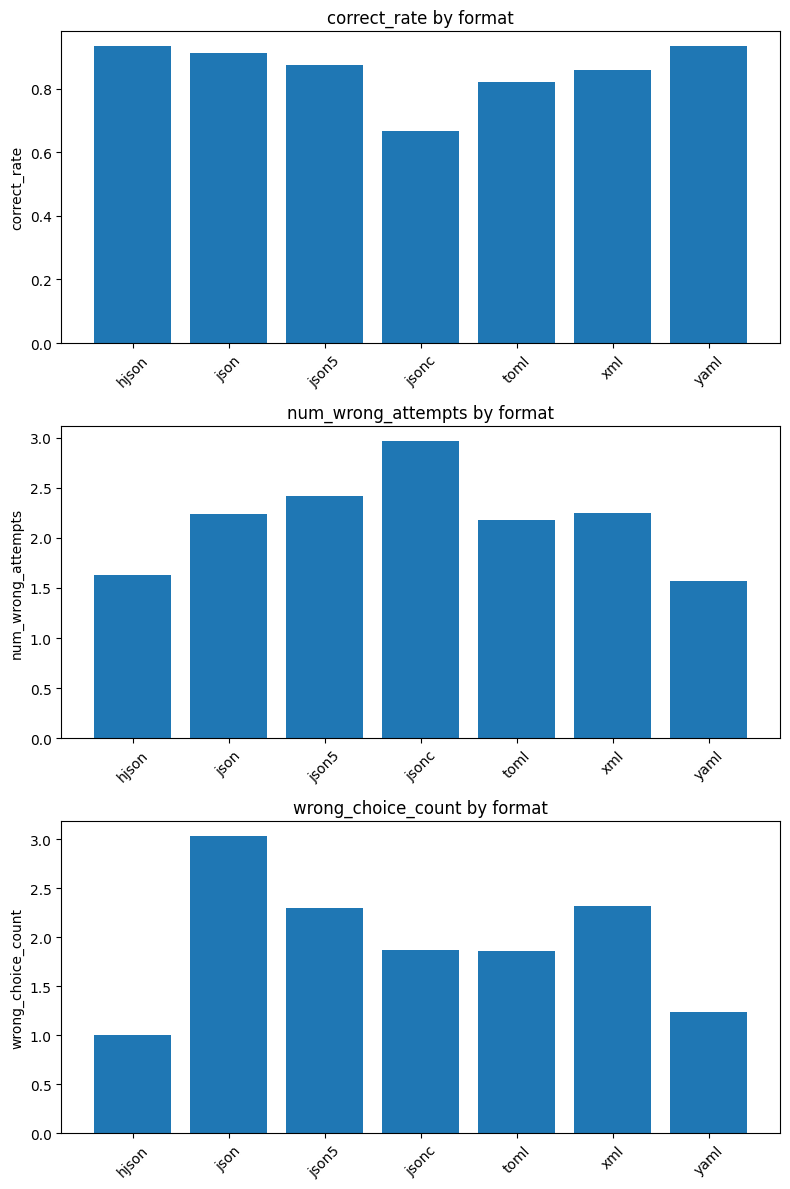

In [2]:
from quiz_evaluator import (
    evaluate_quiz_answers_from_tutorial,
    plot_quiz_metrics_by_group,
    test_quiz_metrics,
    process_quiz_metrics_per_participant
)

df_quiz = evaluate_quiz_answers_from_tutorial(all_data)

fig = plot_quiz_metrics_by_group(
    df_quiz,
    group_by='format',
    metrics=[
      'correct_rate',
      'num_wrong_attempts',
      'wrong_choice_count'
    ],
    format_list=['json', 'xml', 'hjson', 'yaml','jsonc', 'json5', 'toml']
)
fig.show()

In [3]:
# 1) Preprocess to per‐participant summary
df_part_summary, df_format_mean = process_quiz_metrics_per_participant(
    df_quiz,
    format_list=['json', 'xml', 'hjson', 'yaml','jsonc', 'json5', 'toml']
)

# 2) Test quiz metrics
results = test_quiz_metrics(
    df_part_summary,
    metrics=['correct_rate','num_wrong_attempts','wrong_choice_count'],
    alpha=0.05
)

# 3) View interpretations
for metric, info in results.items():
    print(info['interpretation'])
    if info['tukey'] is not None:
        print(info['tukey'].summary())


Metric 'correct_rate': Levene’s test p = 0.112 (homogeneous) variances. ANOVA p = 0.080 (≥ 0.05): no significant format differences.
Metric 'num_wrong_attempts': Levene’s test p = 0.288 (homogeneous) variances. ANOVA p = 0.068 (≥ 0.05): no significant format differences.
Metric 'wrong_choice_count': Levene’s test p = 0.273 (homogeneous) variances. ANOVA p = 0.004 (< 0.05): formats differ significantly. See Tukey HSD for pairwise contrasts.
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 hjson   json   2.0294 0.0034  0.4593 3.5995   True
 hjson  json5   1.2917 0.2711 -0.4249 3.0083  False
 hjson  jsonc   0.8667 0.6742 -0.7518 2.4851  False
 hjson   toml   0.8571  0.703 -0.7899 2.5042  False
 hjson    xml   1.3214 0.2031 -0.3256 2.9685  False
 hjson   yaml   0.2333 0.9995 -1.3851 1.8518  False
  json  json5  -0.7377 0.8362 -2.4089 0.9334  False
  json  jsonc  -1.1627 0.2892 -2.732

In [4]:
df_format_mean

,format,correct_rate,num_wrong_attempts,wrong_choice_count
0,hjson,0.933333,1.633333,1.000000
1,json,0.911765,2.235294,3.029412
2,json5,0.875000,2.416667,2.291667
3,jsonc,0.666667,2.966667,1.866667
4,toml,0.821429,2.178571,1.857143
5,xml,0.857143,2.250000,2.321429
6,yaml,0.933333,1.566667,1.233333


/var/folders/hs/htjkkv116fv94g1llc3jj8jc0000gn/T/ipykernel_41946/3471488952.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


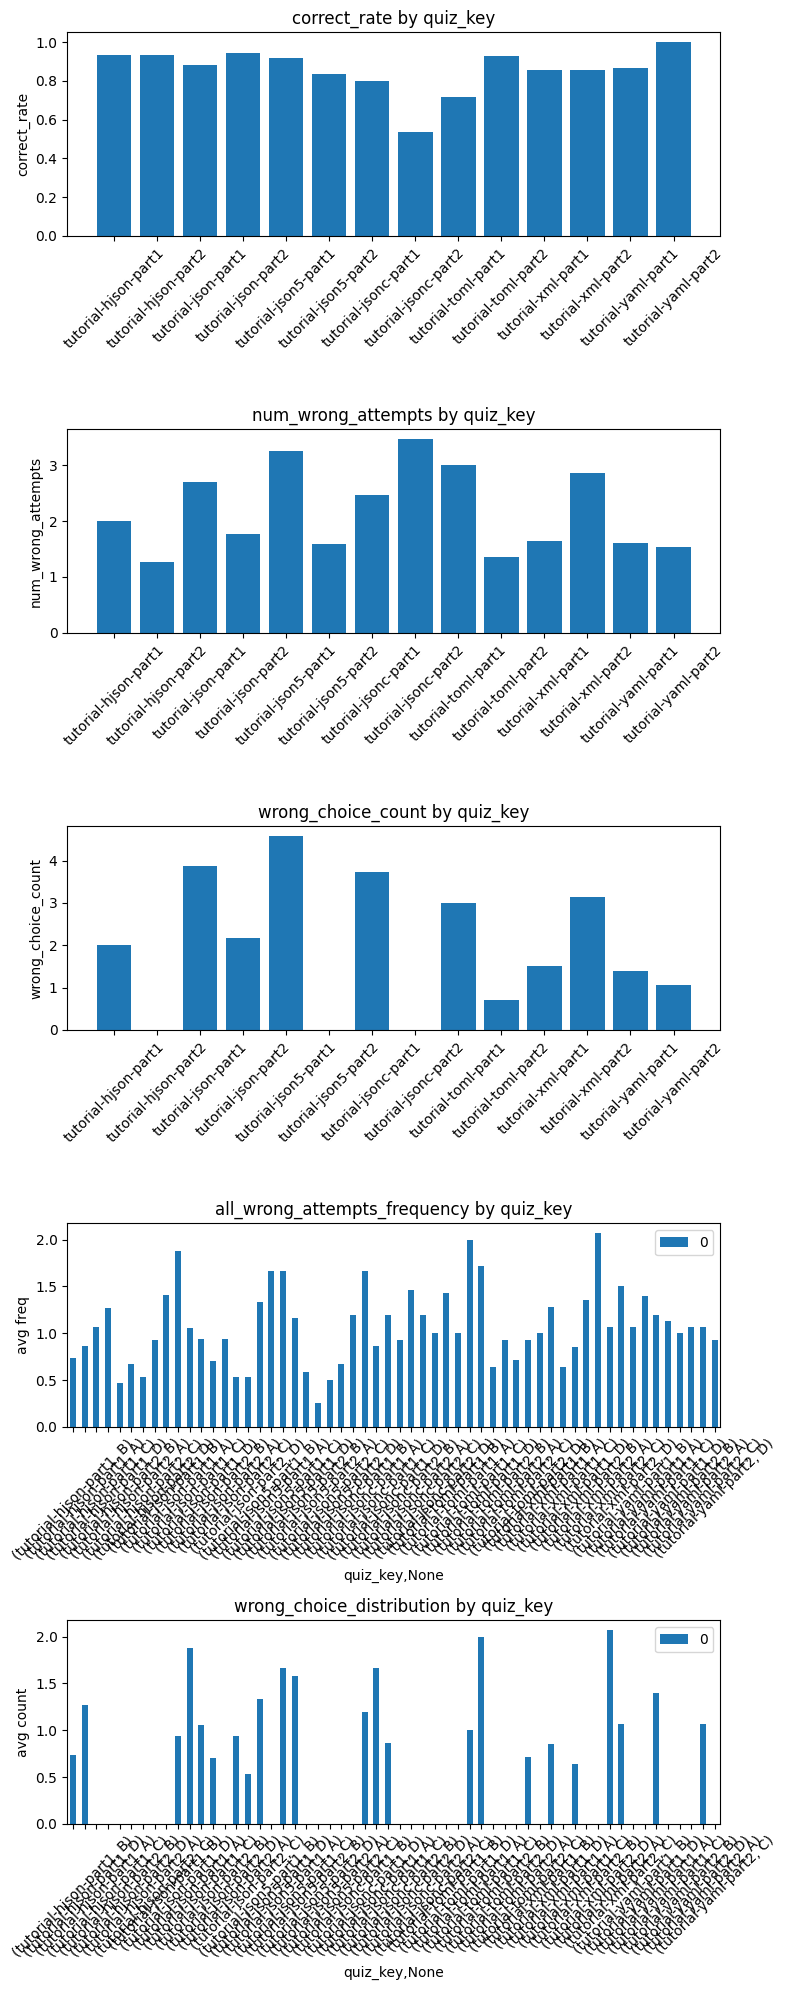

In [5]:
fig = plot_quiz_metrics_by_group(
    df_quiz,
    group_by='quiz_key',
    metrics=[
      'correct_rate',
      'num_wrong_attempts',
      'wrong_choice_count',
      'all_wrong_attempts_frequency',
      'wrong_choice_distribution'
    ],
    format_list=['json', 'xml', 'hjson', 'yaml','jsonc', 'json5', 'toml']
)
fig.show()